In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Fake news detection
The TensorFlow version of neural network
"""
import pickle
import numpy as np
import tensorflow as tf
from getEmbeddings import getEmbeddings
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt
import os.path

IN_DIM = 300
CLASS_NUM = 2
LEARN_RATE = 0.001
TRAIN_STEP = 20000
tensorflow_tmp = "tmp_tensorflow"





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def dummy_input_fn():
    return np.array([1.0] * IN_DIM)

def model_fn(features, labels, mode):
    """The model function for tf.Estimator"""
    # Input layer
    input_layer = tf.reshape(features["x"], [-1, IN_DIM])
    # Dense layer1
    dense1 = tf.layers.dense(inputs=input_layer, units=300, \
        activation=tf.nn.relu)
    # Dropout layer1
    dropout1 = tf.layers.dropout(inputs=dense1, rate=0.4, \
        training=(mode == tf.estimator.ModeKeys.TRAIN))
    # Dense layer2
    dense2 = tf.layers.dense(inputs=dropout1, units=300, \
        activation=tf.nn.relu)
    # Dropout layer2
    dropout2 = tf.layers.dropout(inputs=dense2, rate=0.4, \
        training=(mode == tf.estimator.ModeKeys.TRAIN))
    # Dense layer3
    dense3 = tf.layers.dense(inputs=dropout2, units=300, \
        activation=tf.nn.relu)
    # Dropout layer3
    dropout3 = tf.layers.dropout(inputs=dense3, rate=0.4, \
        training=(mode == tf.estimator.ModeKeys.TRAIN))
    # Logits layer
    logits = tf.layers.dense(inputs=dropout3, units=CLASS_NUM)

    # prediction result in PREDICT and EVAL phases
    predictions = {
        # Class id
        "classes": tf.argmax(input=logits, axis=1),
        # Probabilities
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Calculate Loss for TRAIN and EVAL
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the training Op
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARN_RATE)
        train_op = optimizer.minimize(\
            loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(\
            mode=mode, loss=loss, train_op=train_op)
    
    # Add evaluation metrics
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(\
            labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(\
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import logging

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# Get the training and testing data from getEmbeddings
if not os.path.isfile('./xtr.npy') or \
        not os.path.isfile('./xte.npy') or \
        not os.path.isfile('./ytr.npy') or \
        not os.path.isfile('./yte.npy'):
        xtr,xte,ytr,yte = getEmbeddings("datasets/train.csv")
        np.save('./xtr', xtr)
        np.save('./xte', xte)
        np.save('./ytr', ytr)
        np.save('./yte', yte)
# Read the Doc2Vec data
train_data = np.load('./xtr.npy')
eval_data = np.load('./xte.npy')
train_labels = np.load('./ytr.npy')
eval_labels = np.load('./yte.npy')
train_labels = np.where(train_labels<1, 1, 0)
eval_labels = np.where(eval_labels<1, 1, 0)
train_labels = train_labels.reshape((-1, 1)).astype(np.int32)
eval_labels = eval_labels.reshape((-1, 1)).astype(np.int32)

# Create the Estimator
classifier = \
        tf.estimator.Estimator(model_fn=model_fn, model_dir=tensorflow_tmp)

# Setup logging hook for prediction
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
tensors=tensors_to_log, every_n_iter=200)
    
    
    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tmp_tensorflow', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": train_data},
        y=train_labels,
        batch_size=128,
        num_epochs=8,
        shuffle=True)
classifier.train(
        input_fn=train_input_fn,
        steps=TRAIN_STEP,
        hooks=[logging_hook])


with open('tf.sav', 'wb') as files:
    pickle.dump(classifier, files)
        
    

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py/lib/python3.7/site-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: `tf.layers.dropout` is deprecated and

In [ ]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": eval_data},
        y=eval_labels,
        num_epochs=1,
        shuffle=False)
eval_results = classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)  
    
#Predictions
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": eval_data},
        num_epochs=1,
        shuffle=False)
predict_results = classifier.predict(input_fn=predict_input_fn)
predict_labels = [label["classes"] for label in predict_results]
    

INFO:tensorflow:Calling model_fn.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  del sys.path[0]
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  app.launch_new_instance()
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead

In [ ]:
y_test=eval_labels
y_pred=predict_labels

m = y_test.shape[0]
tp=0
tn=0
fp=0
fn=0
for i in range(m):
    if (y_pred[i]==0 and (y_test[i]!=y_pred[i])):
        fn+=1
    elif (y_pred[i]==1 and (y_test[i]!=y_pred[i])):
        fp+=1
    elif (y_pred[i]==0 and (y_test[i]==y_pred[i])):
        tn+=1
    elif (y_pred[i]==1 and (y_test[i]==y_pred[i])):
        tp+=1

precision=(tp)/(tp+fp)*100
recall=(tp)/(tp+fn)*100
print("Accuracy = " + format((tp+tn)/(tp+tn+fp+fn)*100, '.2f') + "%")   
print("F1-Score = " + format(((2*precision*recall)/(precision+recall)), '.2f') + "%")   
print("Recall = " + format((tp)/(tp+fn)*100, '.2f') + "%")   
print("Precision = " + format((tp)/(tp+fp)*100, '.2f') + "%")   
print("Specificity = " + format((tn)/(tn+fp)*100, '.2f') + "%")  

Accuracy = 73.74%
F1-Score = 76.51%
Recall = 85.93%
Precision = 68.95%
Specificity = 61.65%


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


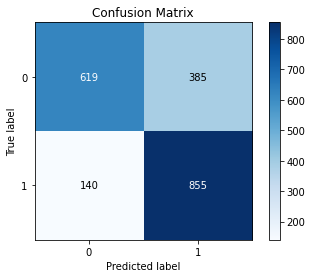

In [ ]:
# Draw the confusion matrix
def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.grid(False)
    plt.show()
    
plot_cmat(eval_labels, predict_labels)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3a2c2a1b-c190-4238-a7b0-93cabb99b4e1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>